In [ ]:
#!pip install pyvi
#!pip install tqdm


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight
from gensim import models
import torch
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize
from tqdm import tqdm
import numpy as np

In [ ]:
def replace_values(value):
    if value == 0:
        return np.nan  # Thay 0 thành null (NaN)
    elif value == 1:
        return 0
    elif value == 2:
        return 1
    elif value == 3:
        return 2
    return value


data_train = pd.read_csv('/kaggle/input/sentimentabsa/data_train.csv')
data_val = pd.read_csv('/kaggle/input/sentimentabsa/data_val.csv')
data_test = pd.read_csv('/kaggle/input/sentimentabsa/data_test.csv')

# Áp dụng hàm thay thế cho các cột A, B, C, D
columns_to_replace = ['Quality', 'Smell', 'Shipping', 'Packing', 'Price', 'Other', 'General']
data_train[columns_to_replace] = data_train[columns_to_replace].applymap(replace_values)
data_test[columns_to_replace] = data_test[columns_to_replace].applymap(replace_values)
data_val[columns_to_replace] = data_val[columns_to_replace].applymap(replace_values)


data_train.drop('Unnamed: 0', axis = 1, inplace = True)
data_val.drop('Unnamed: 0', axis = 1, inplace = True)
data_test.drop('Unnamed: 0', axis = 1, inplace = True)
data_test.rename(columns={'Tokenized': 'processed_content'}, inplace=True)
data_train.rename(columns={'Tokenized': 'processed_content'}, inplace=True)
data_val.rename(columns={'Tokenized': 'processed_content'}, inplace=True)
data_test.rename(columns={'Quality': 'quality'}, inplace=True)
data_train.rename(columns={'Quality': 'quality'}, inplace=True)
data_val.rename(columns={'Quality': 'quality'}, inplace=True)
data_train.rename(columns={'Smell': 'smell'}, inplace=True)
data_test.rename(columns={'Smell': 'smell'}, inplace=True)
data_val.rename(columns={'Smell': 'smell'}, inplace=True)
data_val.rename(columns={'Shipping': 'shipping'}, inplace=True)
data_train.rename(columns={'Shipping': 'shipping'}, inplace=True)
data_test.rename(columns={'Shipping': 'shipping'}, inplace=True)
data_test.rename(columns={'Packing': 'packing'}, inplace=True)
data_train.rename(columns={'Packing': 'packing'}, inplace=True)
data_val.rename(columns={'Packing': 'packing'}, inplace=True)
data_train.rename(columns={'Price': 'price'}, inplace=True)
data_val.rename(columns={'Price': 'price'}, inplace=True)
data_test.rename(columns={'Price': 'price'}, inplace=True)
data_val.rename(columns={'Other': 'others'}, inplace=True)
data_test.rename(columns={'Other': 'others'}, inplace=True)
data_train.rename(columns={'Other': 'others'}, inplace=True)

<ipython-input-6-1b4dc075d9a1>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_train[columns_to_replace] = data_train[columns_to_replace].applymap(replace_values)
<ipython-input-6-1b4dc075d9a1>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_test[columns_to_replace] = data_test[columns_to_replace].applymap(replace_values)
<ipython-input-6-1b4dc075d9a1>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_val[columns_to_replace] = data_val[columns_to_replace].applymap(replace_values)


In [ ]:
replace_dict = {0:1, 1:2,2:3}
data_train = data_train.replace(replace_dict).fillna(0)
data_val= data_val.replace(replace_dict).fillna(0)
data_test = data_test.replace(replace_dict).fillna(0)

In [ ]:
data_train

,Content,General,others,packing,price,quality,shipping,smell,processed_content
0,mềm nhẹ nhàng,0.0,0.0,0.0,0.0,3.0,0.0,0.0,mềm nhẹ_nhàng
1,vẫn cảm thấy hơi khô da,0.0,0.0,0.0,0.0,1.0,0.0,0.0,vẫn cảm_thấy hơi khô da
2,rẻ nên mua nha mọi người,0.0,0.0,0.0,3.0,0.0,0.0,0.0,rẻ nên mua nha mọi người
3,shop rất nhiệt tình sản phẩm đáng mua,3.0,0.0,0.0,0.0,0.0,0.0,0.0,shop rất nhiệt_tình sản_phẩm đáng mua
4,còn về mặt sản phẩm thì chỉ không ưng ý cái ch...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,còn về mặt sản_phẩm thì chỉ không ưng_ý cái ch...
...,...,...,...,...,...,...,...,...,...
10193,mua lần rồi phân chính hãng,3.0,0.0,0.0,0.0,0.0,0.0,0.0,mua lần rồi phân chính hãng
10194,sài lắm nha không bị kích hay gì đâu mình lần ...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,sài lắm nha không bị kích hay gì đâu mình lần ...
10195,shipper giao thân thiện,0.0,0.0,0.0,0.0,0.0,3.0,0.0,shipper giao thân_thiện
10196,sẽ quay ủng shop tiếp okela,3.0,0.0,0.0,0.0,0.0,0.0,0.0,sẽ quay ủng shop tiếp okela


In [ ]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)-1):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [ ]:
label_train = make_outputs(data_train)
label_val = make_outputs(data_val)
label_test = make_outputs(data_test)

print('Train outputs:', label_train.shape)
print('Validate outputs:', label_val.shape)
print('Test outputs:', label_test.shape)

Train outputs: (10198, 7, 4)
Validate outputs: (2186, 7, 4)
Test outputs: (2185, 7, 4)


In [ ]:
embeddings = {}
for state in ['train','val','test']:
  embeddings[state] = np.load(f'/kaggle/input/embedding/embeddings_{state}.npy')

In [ ]:
print('Train inputs:', embeddings['train'].shape)
print('Validate inputs:', embeddings['val'].shape)
print('Test intputs:', embeddings['test'].shape)

Train inputs: (10198, 768)
Validate inputs: (2186, 768)
Test intputs: (2185, 768)


In [ ]:
list_aspect = data_train.columns[1:-1]

# BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # TimeDistributed layers to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(lstm_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(output_dim, activation='softmax'))(aspect_dense3)  # Adjusted to output_dim

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense4)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 7
output_dim = 4  # Ensure this matches the number of categories/classes you have

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train  # Ensure shape (None, 6, 4)
label_aspect_val = label_val      # Ensure shape (None, 6, 4)

callback = EarlyStopping(monitor='val_loss', patience=5)
model_lstm, history_lstm = bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7097 - loss: 0.8756 - val_accuracy: 0.8588 - val_loss: 0.4497
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8594 - loss: 0.4475 - val_accuracy: 0.8594 - val_loss: 0.4003
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8650 - loss: 0.3948 - val_accuracy: 0.8743 - val_loss: 0.3399
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8834 - loss: 0.3262 - val_accuracy: 0.9091 - val_loss: 0.2687
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9101 - loss: 0.2662 - val_accuracy: 0.9179 - val_loss: 0.2419
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9184 - loss: 0.2426 - val_accuracy: 0.9235 - val_loss: 0.2276
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9234 - loss: 0.2259 - val_accuracy: 0.9269 - val_loss: 0.2186
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9284 - loss: 0.2134 - val_accuracy: 0.

In [ ]:
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 7, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 7, 400)              │       1,550,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 7, 128)              │          51,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 7, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 7, 4)                │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,830,734 (18.43 MB)

 Trainable params: 1,610,244 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,220,490 (12.29 MB)

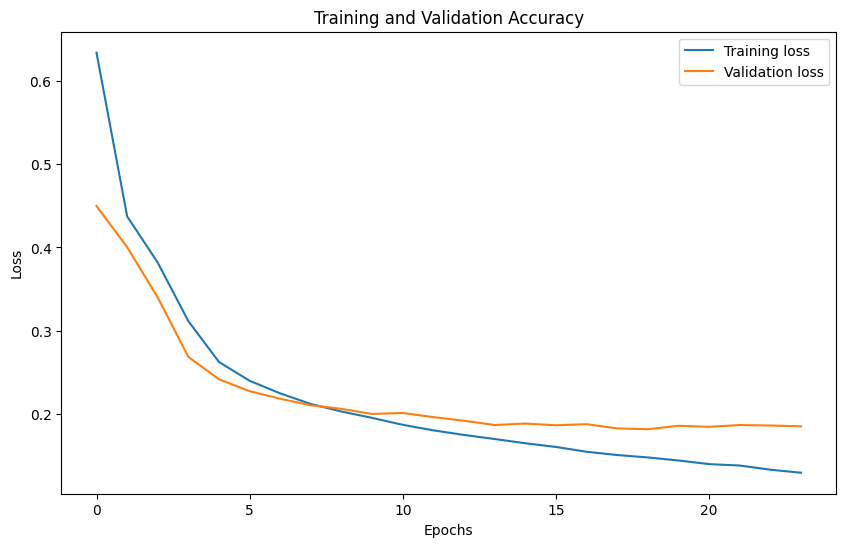

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training loss')
plt.plot(history_lstm.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1)
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category}: {sentiment}')

### Result

In [ ]:
# Kiểm tra classes cho từng aspect
output_lstm = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"\nEvaluating aspect: {aspect_name}")

    # Kiểm tra các classes có trong dữ liệu của aspect hiện tại
    current_true_classes = np.unique(true_labels[:, i])
    current_pred_classes = np.unique(predicted_labels[:, i])
    current_classes = np.unique(np.concatenate([current_true_classes, current_pred_classes]))
    print(f"Classes in {aspect_name}: {current_classes}")

    # Tạo target_names và labels tương ứng với các classes hiện có
    aspect_target_names = []
    labels = []
    all_names = ['None', 'Negative', 'Neutral', 'Positive']
    for idx in current_classes:
        labels.append(idx)
        aspect_target_names.append(all_names[idx])

    # Tạo classification report với labels được chỉ định
    report = classification_report(true_labels[:, i], predicted_labels[:, i],
                                 labels=labels,
                                 target_names=aspect_target_names,
                                 output_dict=True)

    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name
    output_lstm = pd.concat([output_lstm, aspect_report_df], ignore_index=False)
    print(aspect_report_df)


Evaluating aspect: General
Classes in General: [0 1 2 3]
              precision    recall  f1-score      support   Aspect
None           0.837209  0.898129  0.866600  1443.000000  General
Negative       0.500000  0.448276  0.472727    29.000000  General
Neutral        0.318182  0.225806  0.264151    62.000000  General
Positive       0.742504  0.646697  0.691297   651.000000  General
accuracy       0.798169  0.798169  0.798169     0.798169  General
macro avg      0.599474  0.554727  0.573694  2185.000000  General
weighted avg   0.789790  0.798169  0.792048  2185.000000  General

Evaluating aspect: others
Classes in others: [0 2 3]
              precision    recall  f1-score      support  Aspect
None           0.984397  0.997211  0.990762  2151.000000  others
Neutral        0.000000  0.000000  0.000000    21.000000  others
Positive       0.000000  0.000000  0.000000    13.000000  others
accuracy       0.981693  0.981693  0.981693     0.981693  others
macro avg      0.328132  0.332404  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
output_lstm.to_csv('/kaggle/working/sentiment_bilstm.csv')

In [ ]:

# Đánh giá mô hình với cả dữ liệu test và nhãn test
y_pred_lstm = predict(model_lstm, embeddings['test'], verbose=1)
evaluation = model_lstm.evaluate(embeddings['test'], label_test, verbose=1)

# In ra các metrics
metrics_names = model_lstm.metrics_names
for metric, value in zip(metrics_names, evaluation):
    print(f"{metric}: {value}")

2185/2185 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9382 - loss: 0.1741
loss: 0.18872444331645966
compile_metrics: 0.9344230890274048


In [ ]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = data_test.columns[1:]
print('Example:', data_test['Content'][6])
print_acsa_pred(replacements,categories, y_pred_lstm[6])

Example: xài đồ của la roche thì không phải lo xài cực kì tốt cực kì đã luôn ạ
=> quality: neutral


In [ ]:
y_test_argmax = np.argmax(label_test, axis=-1)
y_test_argmax

array([[0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 3],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0]])

In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_test_argmax):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 1.0000    1.0000    1.0000     13135
     General     1.0000    1.0000    1.0000       742
      others     1.0000    1.0000    1.0000        34
     packing     1.0000    1.0000    1.0000       226
       price     1.0000    1.0000    1.0000       203
     quality     1.0000    1.0000    1.0000       604
    shipping     1.0000    1.0000    1.0000       231
       smell     1.0000    1.0000    1.0000       120

    accuracy                         1.0000     15295
   macro avg     1.0000    1.0000    1.0000     15295
weighted avg     1.0000    1.0000    1.0000     15295



In [ ]:
aspect_report_df.to_csv('/kaggle/working/aspect_bilstm.csv')

# BiLSTM + Conv

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # Adding a Conv1D layer after LSTM
    conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(lstm_layer)

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 6 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 7
output_dim = 4

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val

callback = EarlyStopping(monitor='val_loss', patience=5)
model_lstm_conv, history_lstm_conv = bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7622 - loss: 0.9778 - val_accuracy: 0.8588 - val_loss: 0.4488
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8596 - loss: 0.4437 - val_accuracy: 0.8688 - val_loss: 0.3623
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8725 - loss: 0.3527 - val_accuracy: 0.9086 - val_loss: 0.2722
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9101 - loss: 0.2664 - val_accuracy: 0.9214 - val_loss: 0.2332
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9221 - loss: 0.2355 - val_accuracy: 0.9271 - val_loss: 0.2150
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9296 - loss: 0.2128 - val_accuracy: 0.9314 - val_loss: 0.2026
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9335 - loss: 0.1964 - val_accuracy: 0.9343 - val_loss: 0.1941
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9381 - loss: 0.1820 - val_accuracy: 0.

In [ ]:
# Dự đoán bằng mô hình BiLSTM + Conv
predictions = model_lstm_conv.predict(embeddings['test'])

# Convert predictions to class labels (nếu các dự đoán là xác suất, chuyển chúng thành nhãn lớp)
predicted_labels = np.argmax(predictions, axis=-1)

# Chuyển nhãn thực tế (label_test) về dạng nhãn lớp
true_labels = np.argmax(label_test, axis=-1)

# Đảm bảo rằng true_labels và predicted_labels có cùng hình dạng
print(f"Predicted labels shape: {predicted_labels.shape}")
print(f"True labels shape: {true_labels.shape}")

# Khởi tạo DataFrame để lưu kết quả
output_lstm_conv = pd.DataFrame()

# Lặp qua từng aspect (cột) trong dữ liệu
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"\nEvaluating aspect: {aspect_name}")

    # Kiểm tra các classes có trong dữ liệu của aspect hiện tại
    current_true_classes = np.unique(true_labels[:, i])
    current_pred_classes = np.unique(predicted_labels[:, i])
    current_classes = np.unique(np.concatenate([current_true_classes, current_pred_classes]))
    print(f"Classes in {aspect_name}: {current_classes}")

    # Tạo target_names và labels tương ứng với các classes hiện có
    aspect_target_names = []
    labels = []
    all_names = ['None', 'Negative', 'Neutral', 'Positive']
    for idx in current_classes:
        labels.append(idx)
        aspect_target_names.append(all_names[idx])

    # Tạo classification report với labels được chỉ định
    report = classification_report(true_labels[:, i], predicted_labels[:, i],
                                 labels=labels,
                                 target_names=aspect_target_names,
                                 output_dict=True)

    # Chuyển classification report thành DataFrame và thêm tên aspect vào
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name

    # Append báo cáo của aspect này vào DataFrame chính
    output_lstm_conv = pd.concat([output_lstm_conv, aspect_report_df], ignore_index=True)

    # In classification report cho từng aspect
    print(aspect_report_df)

# Lưu kết quả cuối cùng thành tệp CSV
output_lstm_conv.to_csv('/kaggle/working/sentiment_bilstm_conv.csv', index=False)

# In ra thông báo đã lưu
print("\nClassification report has been saved to 'sentiment_bilstm_conv.csv'.")


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted labels shape: (2185, 7)
True labels shape: (2185, 7)

Evaluating aspect: General
Classes in General: [0 1 2 3]
              precision    recall  f1-score     support   Aspect
None           0.856757  0.878725  0.867602  1443.00000  General
Negative       0.500000  0.413793  0.452830    29.00000  General
Neutral        0.450000  0.145161  0.219512    62.00000  General
Positive       0.714070  0.725038  0.719512   651.00000  General
accuracy       0.805950  0.805950  0.805950     0.80595  General
macro avg      0.630207  0.540679  0.564864  2185.00000  General
weighted avg   0.797968  0.805950  0.799585  2185.00000  General

Evaluating aspect: others
Classes in others: [0 2 3]
              precision    recall  f1-score      support  Aspect
None           0.986648  0.996281  0.991441  2151.000000  others
Neutral        0.250000  0.142857  0.181818    21.000000  others
Positive       0.000000  0.000000  0.000000    13.000000  others
accura

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1)
def print_acsa_pred(replacements, categories, sentence_pred):
    # Nếu sentence_pred là mảng, lấy giá trị tối đa cho mỗi lớp
    if isinstance(sentence_pred, np.ndarray):
        sentence_pred = np.argmax(sentence_pred, axis=-1)

    # Ánh xạ các giá trị từ sentence_pred sang sentiment
    sentiments = [replacements[x] for x in sentence_pred]  # Sử dụng list comprehension thay vì map

    # In ra kết quả cho tất cả các categories, chỉ in khi sentiment không phải là None
    for category, sentiment in zip(categories, sentiments):
        if sentiment:  # Kiểm tra xem sentiment có khác None không
            print(f'=> {category}: {sentiment}')

In [ ]:
# Dự đoán với mô hình BiLSTM + Conv
y_pred_lstm_conv = model_lstm_conv.predict(embeddings['test'], verbose=1)

# Đánh giá mô hình với dữ liệu test và nhãn test
evaluation = model_lstm_conv.evaluate(embeddings['test'], label_test, verbose=1)

# In ra các metrics
metrics_names = model_lstm_conv.metrics_names
for metric, value in zip(metrics_names, evaluation):
    print(f"{metric}: {value}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.1778
loss: 0.19136324524879456
compile_metrics: 0.9369075298309326


In [ ]:
# Ví dụ sử dụng
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = data_test.columns[1:]  # Cột từ dữ liệu test
print('Example:', data_test['Content'][6])  # In ra nội dung ví dụ
print_acsa_pred(replacements, categories, y_pred_lstm_conv[6])  # Gọi hàm với kết quả dự đoán


Example: xài đồ của la roche thì không phải lo xài cực kì tốt cực kì đã luôn ạ
=> quality: neutral


In [ ]:
y_test_argmax = np.argmax(label_test, axis=-1)
y_test_argmax

array([[0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 3],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0]])

In [ ]:
aspect_test = []
aspect_pred = []

# Giả sử y_test_argmax và y_pred_lstm_conv đều là mảng 2D, với shape (num_samples, num_aspects)
for row_test, row_pred in zip(y_test_argmax, y_pred_lstm_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        # Dùng np.argmax nếu col_pred là mảng (để lấy chỉ số lớp)
        if isinstance(col_pred, np.ndarray):
            col_pred = np.argmax(col_pred)
        # Kiểm tra xem giá trị có phải là lớp hợp lệ (không phải None) và ánh xạ đến category
        aspect_test.append(bool(col_test) * categories[index])  # Nếu col_test có giá trị, append category
        aspect_pred.append(bool(col_pred) * categories[index])  # Nếu col_pred có giá trị, append category


In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/kaggle/working/aspect_bilstm_conv.csv')

              precision    recall  f1-score   support

                 0.9593    0.9747    0.9670     13135
     General     0.7518    0.7143    0.7326       742
      others     0.3846    0.1471    0.2128        34
     packing     0.9730    0.7965    0.8759       226
       price     0.8242    0.6700    0.7391       203
     quality     0.8613    0.7401    0.7961       604
    shipping     0.8571    0.8831    0.8699       231
       smell     0.9274    0.9583    0.9426       120

    accuracy                         0.9428     15295
   macro avg     0.8173    0.7355    0.7670     15295
weighted avg     0.9407    0.9428    0.9411     15295



# BiGRU

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(GRU(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # TimeDistributed layers to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(lstm_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(output_dim, activation='softmax'))(aspect_dense3)  # Adjusted to output_dim

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense4)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 7
output_dim = 4  # Ensure this matches the number of categories/classes you have

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train  # Ensure shape (None, 6, 4)
label_aspect_val = label_val      # Ensure shape (None, 6, 4)

callback = EarlyStopping(monitor='val_loss', patience=5)
model_GRU, history_GRU = bilstm_aspect(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7492 - loss: 0.8463 - val_accuracy: 0.8588 - val_loss: 0.4501
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8601 - loss: 0.4543 - val_accuracy: 0.8611 - val_loss: 0.4018
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8655 - loss: 0.4015 - val_accuracy: 0.8763 - val_loss: 0.3403
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8821 - loss: 0.3314 - val_accuracy: 0.9052 - val_loss: 0.2794
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9022 - loss: 0.2802 - val_accuracy: 0.9165 - val_loss: 0.2491
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9135 - loss: 0.2518 - val_accuracy: 0.9203 - val_loss: 0.2333
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9189 - loss: 0.2373 - val_accuracy: 0.9219 - val_loss: 0.2234
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9227 - loss: 0.2232 - val_accuracy: 0.

In [ ]:
# Dự đoán từ mô hình GRU
predictions = model_GRU.predict(embeddings['test'])
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Đánh giá mô hình và lưu kết quả vào DataFrame
output_GRU = pd.DataFrame()

# Lặp qua từng aspect
for i in range(num_aspects):
    aspect_name = data_train.columns[i + 1]
    print(f"\nEvaluating aspect: {aspect_name}")

    # Kiểm tra classes có trong dữ liệu của aspect hiện tại
    current_true_classes = np.unique(true_labels[:, i])
    current_pred_classes = np.unique(predicted_labels[:, i])
    current_classes = np.unique(np.concatenate([current_true_classes, current_pred_classes]))
    print(f"Classes in {aspect_name}: {current_classes}")

    # Tạo target_names và labels tương ứng
    aspect_target_names = []
    labels = []
    all_names = ['None', 'Negative', 'Neutral', 'Positive']
    for idx in current_classes:
        labels.append(idx)
        aspect_target_names.append(all_names[idx])

    # Tạo classification report với labels đã xác định
    report = classification_report(true_labels[:, i], predicted_labels[:, i],
                                 labels=labels,
                                 target_names=aspect_target_names,
                                 output_dict=True)

    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name
    output_GRU = pd.concat([output_GRU, aspect_report_df], ignore_index=True)
    print(aspect_report_df)

# Lưu kết quả
output_GRU.to_csv('/kaggle/working/sentiment_GRU.csv', index=False)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Evaluating aspect: General
Classes in General: [0 1 2 3]
              precision    recall  f1-score      support   Aspect
None           0.847213  0.895357  0.870620  1443.000000  General
Negative       0.428571  0.413793  0.421053    29.000000  General
Neutral        0.379310  0.177419  0.241758    62.000000  General
Positive       0.741294  0.686636  0.712919   651.000000  General
accuracy       0.806407  0.806407  0.806407     0.806407  General
macro avg      0.599097  0.543301  0.561587  2185.000000  General
weighted avg   0.796822  0.806407  0.799823  2185.000000  General

Evaluating aspect: others
Classes in others: [0 2 3]
              precision    recall  f1-score      support  Aspect
None           0.986654  0.996746  0.991674  2151.000000  others
Neutral        0.272727  0.142857  0.187500    21.000000  others
Positive       0.000000  0.000000  0.000000    13.000000  others
accuracy       0.982609  0.982609  0.982609     0.982609  oth

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Dự đoán từ mô hình GRU
y_pred_GRU = predict(model_GRU, embeddings['test'], verbose=1)

# Đánh giá mô hình trên dữ liệu test
evaluation = model_GRU.evaluate(embeddings['test'], label_test, verbose=1)

# In ra các metrics (precision, recall, f1-score...) từ kết quả evaluation
metrics_names = model_GRU.metrics_names
for metric, value in zip(metrics_names, evaluation):
    print(f"{metric}: {value}")


2185/2185 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9402 - loss: 0.1628
loss: 0.17616702616214752
compile_metrics: 0.9370384216308594


In [ ]:
def print_acsa_pred(replacements, categories, sentence_pred):
    # Kiểm tra và chuyển đổi dữ liệu đầu vào
    if isinstance(sentence_pred, np.ndarray):
        if len(sentence_pred.shape) > 1:
            sentence_pred = np.argmax(sentence_pred, axis=-1)

    # Đảm bảo sentence_pred là array
    if isinstance(sentence_pred, (np.int64, int)):
        sentence_pred = np.array([sentence_pred])

    # Ánh xạ sentiment và in kết quả
    for category, pred in zip(categories, sentence_pred):
        sentiment = replacements.get(pred)  # Sử dụng .get() để tránh KeyError
        if sentiment is not None:  # Chỉ in nếu có sentiment
            print(f'=> {category}: {sentiment}')

# Ánh xạ đúng với 4 classes (0: None, 1: Negative, 2: Neutral, 3: Positive)
replacements = {
    0: 'None',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive'
}

# Lấy tên các aspects từ dữ liệu
categories = data_test.columns[1:]

# In ví dụ
print('Example:', data_test['Content'][3])
print_acsa_pred(replacements, categories, y_pred_GRU[3])

Example: khá ưng
=> General: Positive
=> others: None
=> packing: None
=> price: None
=> quality: None
=> shipping: None
=> smell: None


In [ ]:
y_test_argmax = np.argmax(label_test, axis=-1)
y_test_argmax

array([[0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 0, 3],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 0, 0]])

In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_GRU):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.9623    0.9719    0.9671     13135
     General     0.7712    0.6860    0.7261       742
      others     0.4167    0.1471    0.2174        34
     packing     0.9585    0.8186    0.8831       226
       price     0.8226    0.7537    0.7866       203
     quality     0.7911    0.8212    0.8058       604
    shipping     0.8696    0.8658    0.8677       231
       smell     0.9256    0.9333    0.9295       120

    accuracy                         0.9432     15295
   macro avg     0.8147    0.7497    0.7729     15295
weighted avg     0.9415    0.9432    0.9419     15295



In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/kaggle/working/aspect_GRU.csv')

              precision    recall  f1-score   support

                 0.9623    0.9719    0.9671     13135
     General     0.7712    0.6860    0.7261       742
      others     0.4167    0.1471    0.2174        34
     packing     0.9585    0.8186    0.8831       226
       price     0.8226    0.7537    0.7866       203
     quality     0.7911    0.8212    0.8058       604
    shipping     0.8696    0.8658    0.8677       231
       smell     0.9256    0.9333    0.9295       120

    accuracy                         0.9432     15295
   macro avg     0.8147    0.7497    0.7729     15295
weighted avg     0.9415    0.9432    0.9419     15295



# BiGRU + Conv

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(GRU(units=200, activation='tanh', return_sequences=True))(input_expanded)

    # Adding a Conv1D layer after LSTM
    conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(lstm_layer)

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 6 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 7
output_dim = 4

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val

callback = EarlyStopping(monitor='val_loss', patience=5)
model_gru_conv, history_gru_conv = bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8127 - loss: 0.9308 - val_accuracy: 0.8588 - val_loss: 0.4950
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8594 - loss: 0.4791 - val_accuracy: 0.8588 - val_loss: 0.3735
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8651 - loss: 0.3723 - val_accuracy: 0.9007 - val_loss: 0.2941
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8986 - loss: 0.2923 - val_accuracy: 0.9147 - val_loss: 0.2535
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9139 - loss: 0.2560 - val_accuracy: 0.9201 - val_loss: 0.2346
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9206 - loss: 0.2366 - val_accuracy: 0.9243 - val_loss: 0.2207
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9270 - loss: 0.2195 - val_accuracy: 0.9289 - val_loss: 0.2122
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9297 - loss: 0.2083 - val_accuracy: 0.

In [ ]:
predictions = model_gru_conv.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_GRU_conv = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_GRU_conv = pd.concat([output_GRU_conv, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df)
    output_GRU_conv.to_csv('/kaggle/working/sentiment_GRU_conv.csv')

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
General:
              precision    recall  f1-score      support   Aspect
None           0.888087  0.852391  0.869873  1443.000000  General
Negative       0.419355  0.448276  0.433333    29.000000  General
Neutral        0.355556  0.258065  0.299065    62.000000  General
Positive       0.703039  0.781874  0.740364   651.000000  General
accuracy       0.809153  0.809153  0.809153     0.809153  General
macro avg      0.591509  0.585151  0.585659  2185.000000  General
weighted avg   0.811621  0.809153  0.809296  2185.000000  General
others:
              precision    recall  f1-score      support  Aspect
None           0.987546  0.995351  0.991433  2151.000000  others
Negative       0.000000  0.000000  0.000000     0.000000  others
Neutral        0.272727  0.142857  0.187500    21.000000  others
Positive       0.200000  0.076923  0.111111    13.000000  others
accuracy       0.981693  0.981693  0.981693     0.981693  others
macro avg      0.365068  0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [ ]:
# Dự đoán với mô hình GRU + Conv
y_pred_gru_conv = predict(model_gru_conv, embeddings['test'], verbose=1)

# Đánh giá mô hình GRU + Conv
evaluation_gru_conv = model_gru_conv.evaluate(embeddings['test'], label_test, verbose=1)

# In ra các metrics từ quá trình đánh giá
metrics_names = model_gru_conv.metrics_names
for metric, value in zip(metrics_names, evaluation_gru_conv):
    print(f"{metric}: {value}")


2185/2185 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9426 - loss: 0.1598
loss: 0.1727970987558365
compile_metrics: 0.9384768009185791


In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_gru_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.9652    0.9715    0.9684     13135
     General     0.7338    0.7911    0.7613       742
      others     0.4118    0.2059    0.2745        34
     packing     0.9453    0.8407    0.8899       226
       price     0.8688    0.6847    0.7658       203
     quality     0.8390    0.7765    0.8065       604
    shipping     0.9147    0.8355    0.8733       231
       smell     0.9127    0.9583    0.9350       120

    accuracy                         0.9455     15295
   macro avg     0.8239    0.7580    0.7843     15295
weighted avg     0.9450    0.9455    0.9448     15295



In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/kaggle/working/aspect_gru_conv.csv')

              precision    recall  f1-score   support

                 0.9652    0.9715    0.9684     13135
     General     0.7338    0.7911    0.7613       742
      others     0.4118    0.2059    0.2745        34
     packing     0.9453    0.8407    0.8899       226
       price     0.8688    0.6847    0.7658       203
     quality     0.8390    0.7765    0.8065       604
    shipping     0.9147    0.8355    0.8733       231
       smell     0.9127    0.9583    0.9350       120

    accuracy                         0.9455     15295
   macro avg     0.8239    0.7580    0.7843     15295
weighted avg     0.9450    0.9455    0.9448     15295



# GRU + LSTM + Conv

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, RepeatVector, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the LSTM
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh', return_sequences=True))(input_expanded)
    conv_layer = Conv1D(128, kernel_size=1, padding="same", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool1 = GlobalAveragePooling1D()(conv_layer)
    max_pool1 = GlobalMaxPooling1D()(conv_layer)

    gru_layer = Bidirectional(GRU(units=200, activation='tanh', return_sequences=True))(input_expanded)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(gru_layer)
    avg_pool2 = GlobalAveragePooling1D()(conv_layer)
    max_pool2 = GlobalMaxPooling1D()(conv_layer)


    concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(0.2))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 6 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callback for early stopping
    callback = EarlyStopping(monitor='val_loss', patience=3)
    # Train the model
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model, history

# Example usage
embedding_dim = 768
num_aspects = 7
output_dim = 4

# Example placeholders for embeddings and labels
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val

callback = EarlyStopping(monitor='val_loss', patience=5)
model_lstm_gru_conv, history_lstm_gru_conv = bilstm_conv(embedding_dim, num_aspects, output_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8229 - loss: 0.7476 - val_accuracy: 0.8588 - val_loss: 0.4547
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8599 - loss: 0.4606 - val_accuracy: 0.8588 - val_loss: 0.4244
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8601 - loss: 0.4268 - val_accuracy: 0.8669 - val_loss: 0.3743
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8697 - loss: 0.3670 - val_accuracy: 0.8970 - val_loss: 0.3040
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8958 - loss: 0.2946 - val_accuracy: 0.9130 - val_loss: 0.2530
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9140 - loss: 0.2485 - val_accuracy: 0.9224 - val_loss: 0.2288
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9200 - loss: 0.2291 - val_accuracy: 0.9247 - val_loss: 0.2166
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9277 - loss: 0.2129 - val_accuracy: 0.

In [ ]:
# Dự đoán từ mô hình
predictions = model_lstm_gru_conv.predict(embeddings['test'])
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Khởi tạo DataFrame để lưu kết quả
output_lstm_GRU_conv = pd.DataFrame()

# Lặp qua từng aspect
for i in range(num_aspects):
    aspect_name = data_train.columns[i+1]
    print(f"\nEvaluating aspect: {aspect_name}")

    # Kiểm tra classes có trong dữ liệu của aspect hiện tại
    current_true_classes = np.unique(true_labels[:, i])
    current_pred_classes = np.unique(predicted_labels[:, i])
    current_classes = np.unique(np.concatenate([current_true_classes, current_pred_classes]))
    print(f"Classes in {aspect_name}: {current_classes}")

    # Tạo target_names và labels tương ứng
    aspect_target_names = []
    labels = []
    all_names = ['None', 'Negative', 'Neutral', 'Positive']
    for idx in current_classes:
        labels.append(idx)
        aspect_target_names.append(all_names[idx])

    # Tạo classification report với labels đã xác định
    report = classification_report(true_labels[:, i], predicted_labels[:, i],
                                 labels=labels,
                                 target_names=aspect_target_names,
                                 output_dict=True)

    # Tạo DataFrame từ report và thêm tên aspect
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name

    # Gộp với DataFrame chính
    output_lstm_GRU_conv = pd.concat([output_lstm_GRU_conv, aspect_report_df], ignore_index=False)
    print(aspect_report_df)

# Lưu kết quả
output_lstm_GRU_conv.to_csv('/kaggle/working/sentiment_lstm_GRU_conv.csv', index=True)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Evaluating aspect: General
Classes in General: [0 1 2 3]
              precision    recall  f1-score     support   Aspect
None           0.862517  0.873874  0.868158  1443.00000  General
Negative       0.387097  0.413793  0.400000    29.00000  General
Neutral        0.500000  0.177419  0.261905    62.00000  General
Positive       0.711940  0.732719  0.722180   651.00000  General
accuracy       0.805950  0.805950  0.805950     0.80595  General
macro avg      0.615389  0.549451  0.563061  2185.00000  General
weighted avg   0.801058  0.805950  0.801249  2185.00000  General

Evaluating aspect: others
Classes in others: [0 2 3]
              precision    recall  f1-score      support  Aspect
None           0.987523  0.993491  0.990498  2151.000000  others
Neutral        0.333333  0.190476  0.242424    21.000000  others
Positive       0.000000  0.000000  0.000000    13.000000  others
accuracy       0.979863  0.979863  0.979863     0.979863  others
macr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Dự đoán với mô hình LSTM + GRU + Conv
y_pred_lstm_gru_conv = predict(model_lstm_gru_conv, embeddings['test'], verbose=1)

# Đánh giá mô hình LSTM + GRU + Conv
evaluation_lstm_gru_conv = model_lstm_gru_conv.evaluate(embeddings['test'], label_test, verbose=1)

# In ra các metrics từ quá trình đánh giá
metrics_names = model_lstm_gru_conv.metrics_names
for metric, value in zip(metrics_names, evaluation_lstm_gru_conv):
    print(f"{metric}: {value}")


2185/2185 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9415 - loss: 0.1615
loss: 0.17516165971755981
compile_metrics: 0.9372344017028809


In [ ]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred_lstm_gru_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])


In [ ]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))
aspect_report_df.to_csv('/kaggle/working/aspect_lstm_gru_conv.csv')

              precision    recall  f1-score   support

                 0.9615    0.9736    0.9675     13135
     General     0.7483    0.7291    0.7386       742
      others     0.3333    0.2059    0.2545        34
     packing     0.9028    0.8628    0.8824       226
       price     0.7861    0.7783    0.7822       203
     quality     0.8887    0.7268    0.7996       604
    shipping     0.8981    0.8398    0.8680       231
       smell     0.9194    0.9500    0.9344       120

    accuracy                         0.9438     15295
   macro avg     0.8048    0.7583    0.7784     15295
weighted avg     0.9424    0.9438    0.9427     15295

